# **Factor mining based on machine learning**:

## Team Member

Student Name | Student ID
:---------  | ---------
Li panyu| 2001212358
Li Linxiong| 2001212357

## Project Introduction

In the past 10 years, deep learning models based on neural networks have led the development of artificial intelligence. Different from traditional machine learning, deep learning models directly extract features from raw data and make predictions for targets in an `end-to-end` manner, thereby avoiding manual intervention and information loss in multi-step learning. However, when deep learning is applied to `multi-factor stock selection`, the effect of applying existing models may not meet expectations, and a suitable network structure needs to be tailored. In order to integrate the factor generation and multi-factor synthesis steps in multi-factor stock selection, this project designs a new network structure: `AlphaNet` to `predict the rise or fall` of each stock over the next 10 days, and compare the results with CNN, LogisticRegression and Random Forest.

## Data Analysis

### 1. Data Source
* Stock pool: CSI 300 component stocks from 08/10/2010 to 05/11/2021
* Data: volume and price data of individual stocks without feature engineering, transfer the volume and price data into 9*30 `data pictures `, and 30 is the number of historical days
* Labels: rise or fall of each stock over the next 10 days

**Data sample**  
<div>
    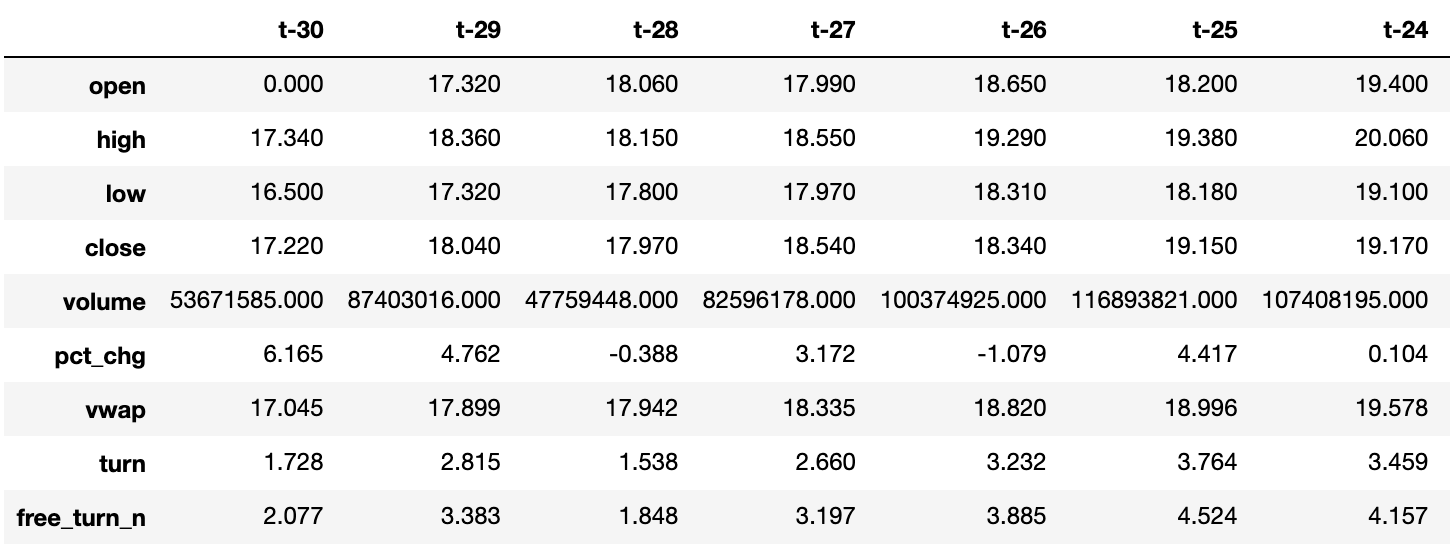
    </div>

### 2. Data cleaning

Deal with missing data: open, high, low, close fill with the previous data; volume, pct_chg, vwap, turn, free_turn_n use 0 to fill NAN. After processing, the data has no NAN values. 

<div>
    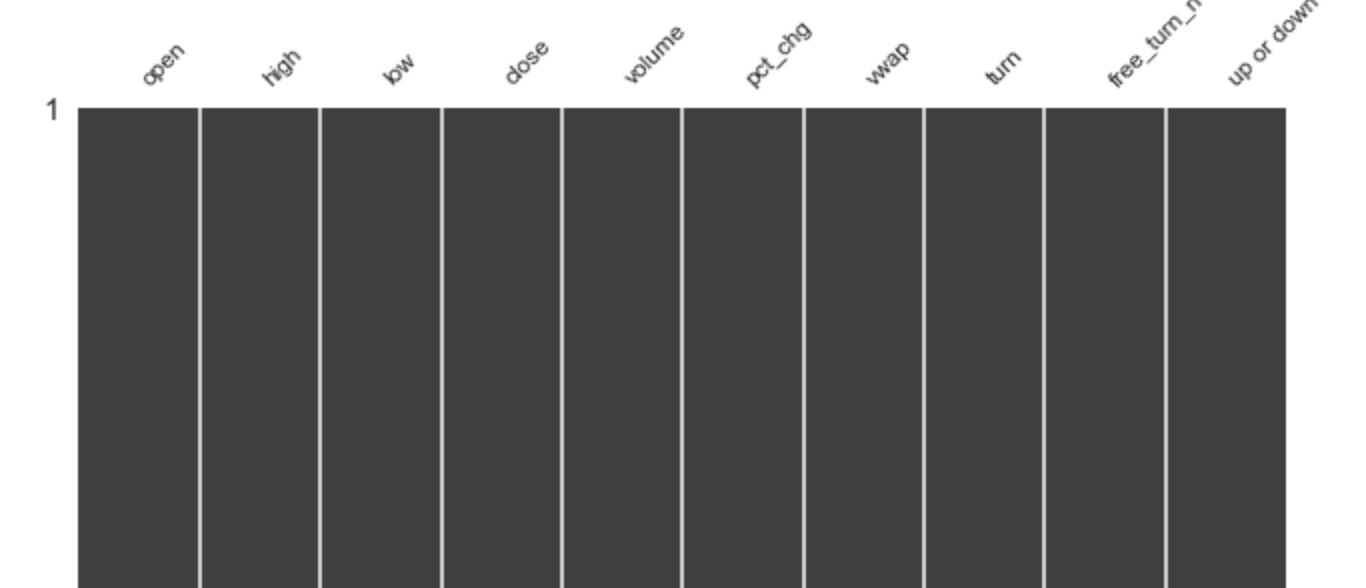
</div>

### 3. Feature Correlation and Distributions

To get a better understanding of the properties of different features, we plot the features `correlations heatmap` and the `distributions` of the features. Through the distributions graph, we can see that most of the features do not have a normal distribution.

<div>
    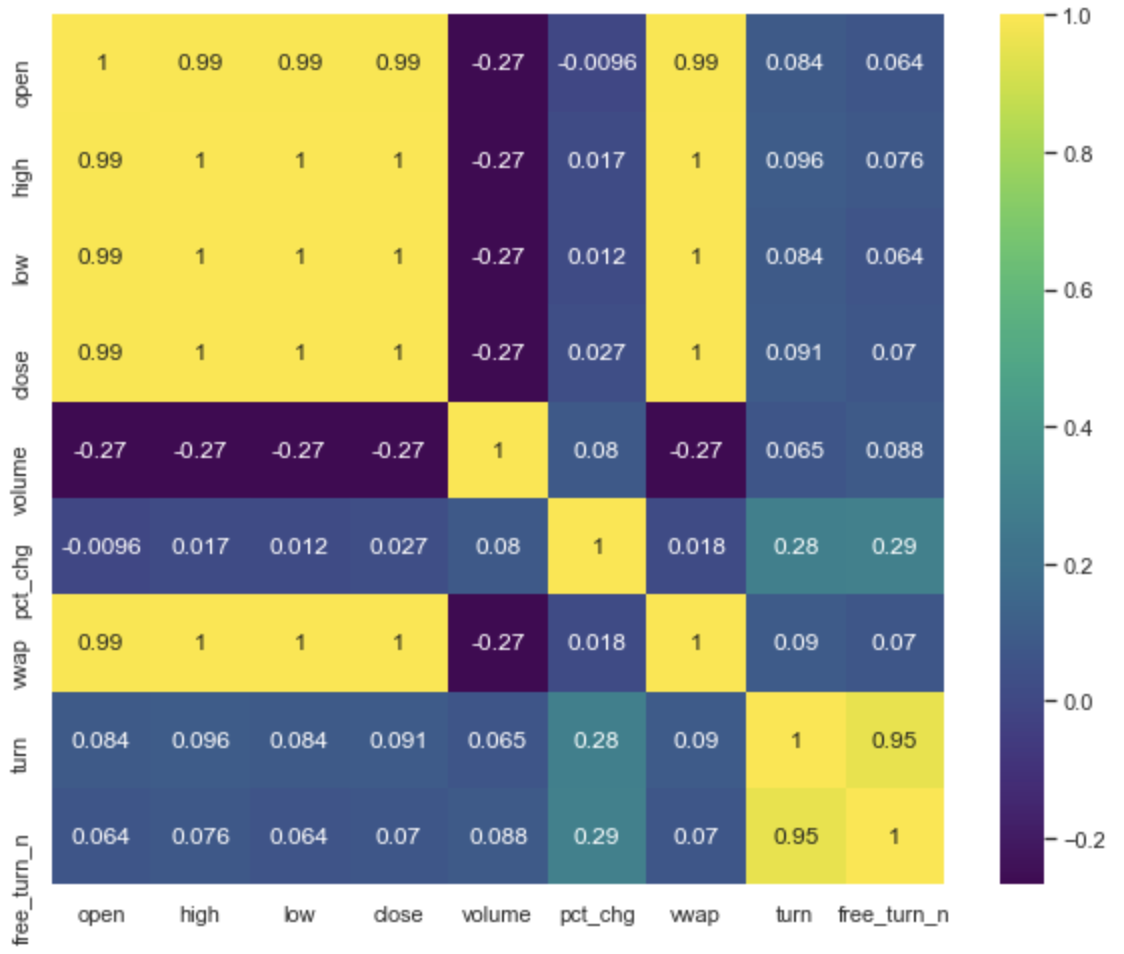
    </div>

<div>
    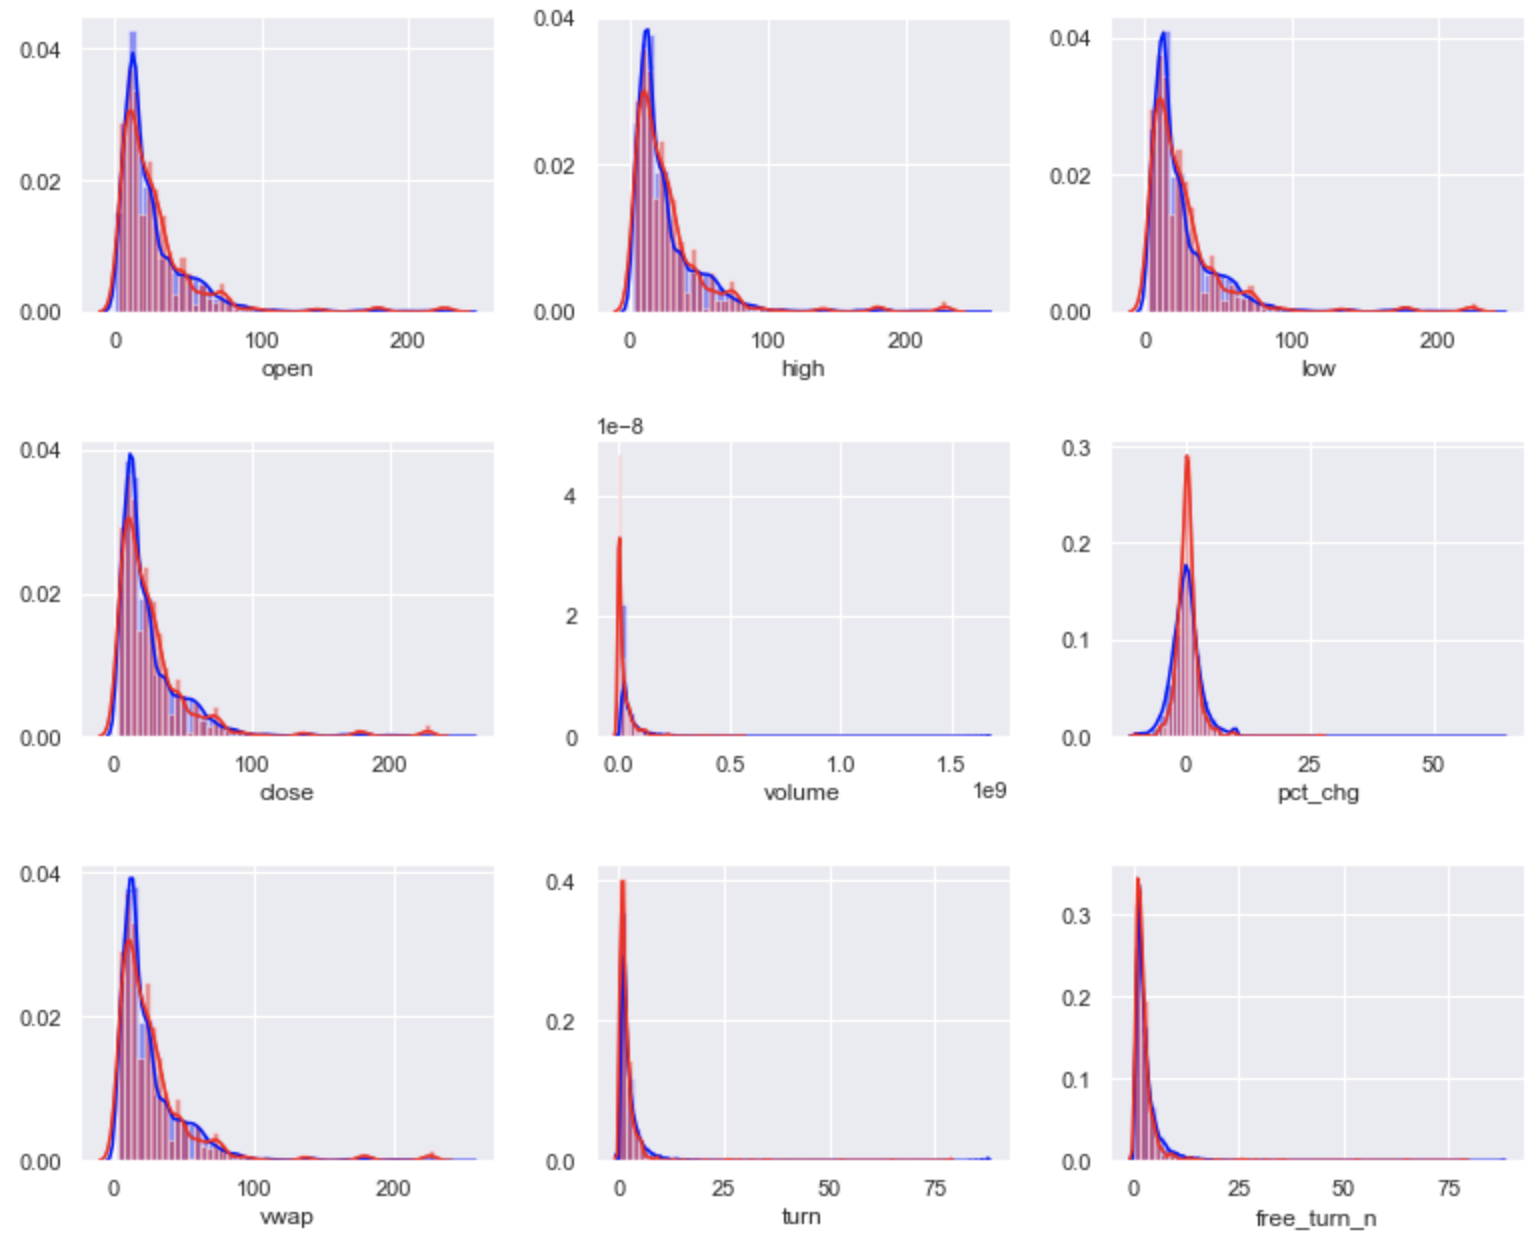
    </div>

## Model

### 1. Alphanet: use price-volume data as input
In order to effectively extract features from the original stock volume and price data, AlphaNet uses the idea of feature construction in genetic programming for reference and uses a variety of operator functions as a custom network layer for feature extraction. AlphaNet consists of four parts: 
* `Data input`: adopting CNN data format, the original volume and price data of individual stocks are sorted into two-dimensional "data pictures"
* `Feature extraction layer`: the most critical part of AlphaNet, it implemented a variety of custom computing network layers to extract features, and use the Batch Normalization layer for feature standardization.
* `Pooling layer`: consistent with pooling layer in CNN, the characteristics of the upper layer are "blurred".
* `Full connection layer`: weighted synthesis of extracted features and uses `sigmoid` activation function to make classification

**Network structure**
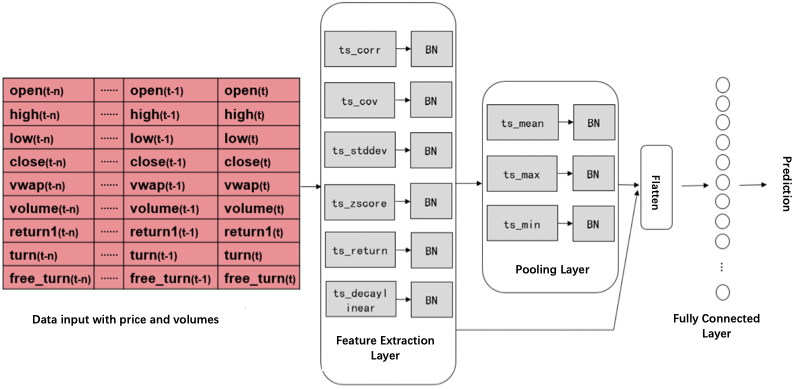

**Example show the process of feature extraction**
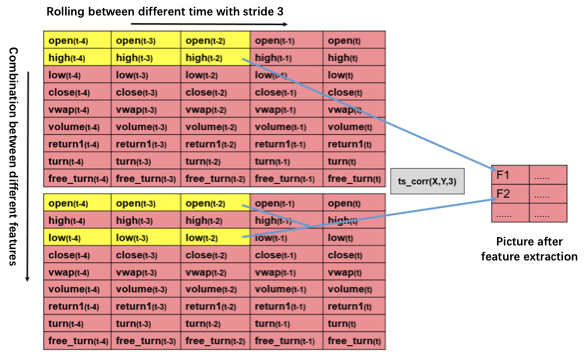

**Network strucuture details**  

Layer name | Components | Parameters
:--- | :--- | :---
Feature extraction | ts_corr(X, Y, stride), ts_cov(X, Y, stride), ts_stddev(X, stride), ts_zscore(X, stride), ts_return(X, stride), ts_decaylinear(X, stride), ts_mean(X, stride), BN | stride=10
Pooling layer | ts_mean(X, stride), ts_max(X, stride), ts_min(X, stride), BN | stride=3
Fully Connected Layer | 30 neurons | dropout rate: 0.5, activation function: relu
Output Layer | 1 neurons | activation function: sigmoid
Other params | Loss function: RMSprop, Learning rate: 0.001

## Factor Validity Test

In [1]:
import BackTest as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Duplicate key in file WindowsPath('C:/Users/18450/anaconda3/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family: SimHei')


In [2]:
# load predicted result
alphanet_predict_w = np.load(file="predict/alphanet_predict_w_0.npy")
cnn_predict_w = np.load(file="predict/cnn_predict_w_0.npy")
lr_predict_w = np.load(file="predict/lr_predict_w_0.npy")
rf_predict_w = np.load(file="predict/randomforest_predict_w_0.npy")
for i in range(1,17):
    alphanet_predict_w0 = np.load(file="predict/alphanet_predict_w_"+str(i)+".npy")
    cnn_predict_w0 = np.load(file="predict/cnn_predict_w_"+str(i)+".npy")
    lr_predict_w0 = np.load(file="predict/lr_predict_w_"+str(i)+".npy")
    rf_predict_w0 = np.load(file="predict/randomforest_predict_w_"+str(i)+".npy")
    
    alphanet_predict_w = np.vstack((alphanet_predict_w, alphanet_predict_w0))
    cnn_predict_w = np.vstack((cnn_predict_w, cnn_predict_w0))
    lr_predict_w = np.vstack((lr_predict_w, lr_predict_w0))
    rf_predict_w = np.vstack((rf_predict_w, rf_predict_w0))
# load trade data
day10_return = np.load('y_data.npy')
daily_return = np.load('daily_return.npy')
ln_mv = np.array(pd.read_excel('val_lnmv.xlsx', skiprows=3, index_col=0))
trade_day = np.array(pd.read_excel('trade_day.xlsx', skiprows=3, index_col=0))
day10_return = day10_return[range(500,len(day10_return),10),:][:-12,:]
ln_mv = np.array(ln_mv)[530:2570,:]
trade_day = np.array(trade_day)[530:2570,:]
daily_return = daily_return[30:2070,:]

### Rank_IC

Firstly, we calculate Rank IC of factors that we get from four different machine learning methods. Rank IC shows the relation between the rank of factors and the rank of asset return. **A high positive or a low negative correlation mean our factor is well explained the asset return and have a good prediction.**

$$Rank\_IC = Corr(Rank(factor),Rank(asset\_return))$$

In order to analyze the incremental information of the synthetic factor, we also show the test results after the market value is neutralized.  

$$factor = \beta_0 + \beta_1 \times ln\_mv$$

$$factor\_mv\_neutral = factor - \hat{factor} = factor - \hat{\beta_0}- \hat{\beta_1} \times ln\_mv$$

In [3]:
alphanet_predict_S1 = bt.SingleFactorValidityTest(factor=pd.DataFrame(alphanet_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                                 mv_neutral=False, mv_weighted=True, ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
alphanet_predict_result1 = alphanet_predict_S1.out_put()

cnn_predict_S1 = bt.SingleFactorValidityTest(factor=pd.DataFrame(cnn_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                             mv_neutral=False, mv_weighted=True, ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
cnn_predict_result1 = cnn_predict_S1.out_put()

lr_predict_S1 = bt.SingleFactorValidityTest(factor=pd.DataFrame(lr_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                           mv_neutral=False, mv_weighted=True, ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
lr_predict_result1 = lr_predict_S1.out_put()

rf_predict_S1 = bt.SingleFactorValidityTest(factor=pd.DataFrame(rf_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                           mv_neutral=False, mv_weighted=True, ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
rf_predict_result1 = rf_predict_S1.out_put()

# ln_market_value neutral
alphanet_predict_S2 = bt.SingleFactorValidityTest(factor=pd.DataFrame(alphanet_predict_w), 
                                                  sto_ret_10day=pd.DataFrame(day10_return),mv_neutral=True, mv_weighted=True,
                                                  ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
alphanet_predict_result2 = alphanet_predict_S2.out_put()

cnn_predict_S2 = bt.SingleFactorValidityTest(factor=pd.DataFrame(cnn_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                             mv_neutral=True, mv_weighted=True,ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
cnn_predict_result2 = cnn_predict_S2.out_put()

lr_predict_S2 = bt.SingleFactorValidityTest(factor=pd.DataFrame(lr_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                            mv_neutral=True, mv_weighted=True,ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
lr_predict_result2 = lr_predict_S2.out_put()

rf_predict_S2 = bt.SingleFactorValidityTest(factor=pd.DataFrame(rf_predict_w), sto_ret_10day=pd.DataFrame(day10_return),
                                            mv_neutral=True, mv_weighted=True,ln_mv=pd.DataFrame(ln_mv[range(0,len(ln_mv),10),:]))
rf_predict_result2 = rf_predict_S2.out_put()

In [4]:
Rank_IC_analyze = pd.DataFrame(index=['alphanet_factor',#'alphanet_mv_neutral_factor',
                                     'cnn_factor','cnn_mv_neutral_factor',
                                     'LR_factor','LR_mv_neutral_factor',
                                     'RF_factor','RF_mv_neutral_factor'],
                          columns=['Rank_IC_mean','Rank_IC_std','Rank_IC_IR','Rank_IC>0'])
Rank_IC_analyze.loc['alphanet_factor',:] = ["%.2f%%" % (alphanet_predict_result1['Rank_IC_mean'] * 100), 
                                "%.2f%%" % (alphanet_predict_result1['Rank_IC'].std() * 100), 
                                "%.2f" % (alphanet_predict_result1['Rank_IC_mean']/alphanet_predict_result1['Rank_IC'].std()),
                                "%.2f%%" % ((alphanet_predict_result1['Rank_IC']>0).sum()/len(alphanet_predict_result1['Rank_IC']) * 100)
                                ]
#Rank_IC_analyze.loc['alphanet_mv_neutral_factor',:] = ["%.2f%%" % (alphanet_predict_result2['Rank_IC_mean'] * 100), 
#                                            "%.2f%%" % (alphanet_predict_result2['Rank_IC'].std() * 100), 
#                                            "%.2f" % (alphanet_predict_result2['Rank_IC_mean']/alphanet_predict_result2['Rank_IC'].std()),
#                                            "%.2f%%" % ((alphanet_predict_result2['Rank_IC']>0).sum()/len(alphanet_predict_result2['Rank_IC']) * 100)
#                                           ]
Rank_IC_analyze.loc['cnn_factor',:] = ["%.2f%%" % (cnn_predict_result1['Rank_IC_mean'] * 100), 
                                "%.2f%%" % (cnn_predict_result1['Rank_IC'].std() * 100), 
                                "%.2f" % (cnn_predict_result1['Rank_IC_mean']/cnn_predict_result1['Rank_IC'].std()),
                                "%.2f%%" % ((cnn_predict_result1['Rank_IC']>0).sum()/len(cnn_predict_result1['Rank_IC']) * 100)
                                ]
Rank_IC_analyze.loc['cnn_mv_neutral_factor',:] = ["%.2f%%" % (cnn_predict_result2['Rank_IC_mean'] * 100), 
                                            "%.2f%%" % (cnn_predict_result2['Rank_IC'].std() * 100), 
                                            "%.2f" % (cnn_predict_result2['Rank_IC_mean']/cnn_predict_result2['Rank_IC'].std()),
                                            "%.2f%%" % ((cnn_predict_result2['Rank_IC']>0).sum()/len(cnn_predict_result2['Rank_IC']) * 100)
                                            ]
Rank_IC_analyze.loc['LR_factor',:] = ["%.2f%%" % (lr_predict_result1['Rank_IC_mean'] * 100), 
                                "%.2f%%" % (lr_predict_result1['Rank_IC'].std() * 100), 
                                "%.2f" % (lr_predict_result1['Rank_IC_mean']/lr_predict_result1['Rank_IC'].std()),
                                "%.2f%%" % ((lr_predict_result1['Rank_IC']>0).sum()/len(lr_predict_result1['Rank_IC']) * 100)
                                ]
Rank_IC_analyze.loc['LR_mv_neutral_factor',:] = ["%.2f%%" % (lr_predict_result2['Rank_IC_mean'] * 100), 
                                            "%.2f%%" % (lr_predict_result2['Rank_IC'].std() * 100), 
                                            "%.2f" % (lr_predict_result2['Rank_IC_mean']/lr_predict_result2['Rank_IC'].std()),
                                            "%.2f%%" % ((lr_predict_result2['Rank_IC']>0).sum()/len(lr_predict_result2['Rank_IC']) * 100)
                                            ]
Rank_IC_analyze.loc['RF_factor',:] = ["%.2f%%" % (rf_predict_result1['Rank_IC_mean'] * 100), 
                                "%.2f%%" % (rf_predict_result1['Rank_IC'].std() * 100), 
                                "%.2f" % (rf_predict_result1['Rank_IC_mean']/rf_predict_result1['Rank_IC'].std()),
                                "%.2f%%" % ((rf_predict_result1['Rank_IC']>0).sum()/len(rf_predict_result1['Rank_IC']) * 100)
                                ]
Rank_IC_analyze.loc['RF_mv_neutral_factor',:] = ["%.2f%%" % (rf_predict_result2['Rank_IC_mean'] * 100), 
                                            "%.2f%%" % (rf_predict_result2['Rank_IC'].std() * 100), 
                                            "%.2f" % (rf_predict_result2['Rank_IC_mean']/rf_predict_result2['Rank_IC'].std()),
                                            "%.2f%%" % ((rf_predict_result2['Rank_IC']>0).sum()/len(rf_predict_result2['Rank_IC']) * 100)
                                            ]
Rank_IC_analyze

Rank_IC_mean Rank_IC_std Rank_IC_IR Rank_IC>0
alphanet_factor               nan%        nan%        nan     0.00%
cnn_factor                   1.64%      10.98%       0.15    36.27%
cnn_mv_neutral_factor        0.68%      12.23%       0.06    35.78%
LR_factor                    0.37%      13.72%       0.03    51.96%
LR_mv_neutral_factor         0.11%      12.63%       0.01    49.51%
RF_factor                    0.22%      11.79%       0.02    52.45%
RF_mv_neutral_factor         0.23%      10.69%       0.02    49.51%

**The synthetic factors do not have a pretty well explanation of asset returns. Copated with logistice regression and random forest, CNN has better correlation with asset returns with a highest mean of Rank_IC.**

**There must something wrong in alphanet since it has no correlation with return. After checking the factor data, we find CNN find nothing after learning. All factors of each stock are totally same.**

In [5]:
pd.DataFrame(alphanet_predict_w)

0         1         2         3         4         5         6    \
0    0.396033  0.396033  0.396033  0.396033  0.396033  0.396033  0.396033   
1    0.396033  0.396033  0.396033  0.396033  0.396033  0.396033  0.396033   
2    0.396033       NaN  0.396033  0.396033  0.396033  0.396033       NaN   
3    0.396033       NaN  0.396033  0.396033  0.396033  0.396033       NaN   
4    0.396033       NaN  0.396033  0.396033  0.396033  0.396033       NaN   
..        ...       ...       ...       ...       ...       ...       ...   
199  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561   
200  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561   
201  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561   
202  0.464561  0.464561       NaN  0.464561  0.464561  0.464561  0.464561   
203  0.464561  0.464561       NaN  0.464561  0.464561  0.464561  0.464561   

          7         8         9    ...       290       291       292  \
0         NaN       NaN  0.396033  ...  0.396033       NaN       NaN   
1         NaN       NaN  0.396033  ...  0.396033       NaN       NaN   
2         NaN       NaN  0.396033  ...  0.396033       NaN       NaN   
3         NaN       NaN  0.396033  ...  0.396033       NaN       NaN   
4         NaN       NaN  0.396033  ...  0.396033       NaN       NaN   
..        ...       ...       ...  ...       ...       ...       ...   
199  0.464561  0.464561  0.464561  ...  0.464561  0.464561  0.464561   
200  0.464561  0.464561  0.464561  ...  0.464561  0.464561  0.464561   
201  0.464561  0.464561  0.464561  ...  0.464561  0.464561  0.464561   
202  0.464561  0.464561  0.464561  ...  0.464561  0.464561  0.464561   
203  0.464561  0.464561  0.464561  ...  0.464561  0.464561  0.464561   

          293       294       295       296       297       298       299  
0         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4         NaN       NaN       NaN       NaN       NaN       NaN       NaN  
..        ...       ...       ...       ...       ...       ...       ...  
199  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  
200  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  
201  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  
202  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  
203  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  0.464561  

[204 rows x 300 columns]

C:\Users\18450\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\18450\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


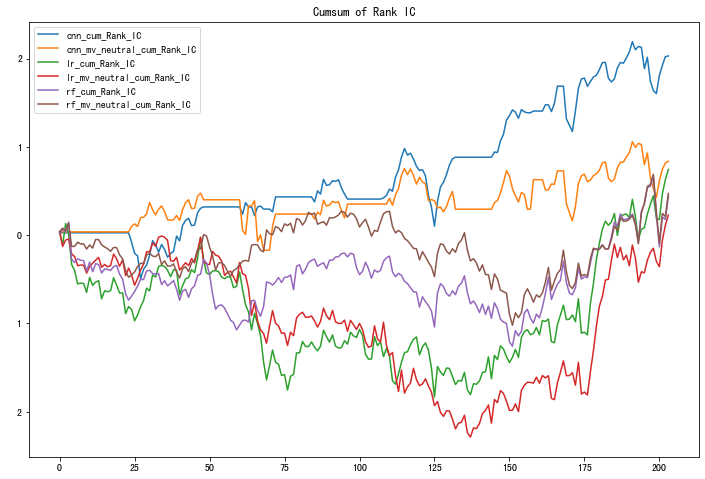

In [6]:
plt.figure(figsize=(12, 8))
plt.title('Cumsum of Rank IC')
#plt.plot(alphanet_predict_result1['cum_Rank_IC'],label = 'alphanet_cum_Rank_IC')
#plt.plot(alphanet_predict_result2['cum_Rank_IC'],label = 'alphanet_mv_neutral_cum_Rank_IC')
plt.plot(cnn_predict_result1['cum_Rank_IC'].fillna(method='bfill'),label = 'cnn_cum_Rank_IC')
plt.plot(cnn_predict_result2['cum_Rank_IC'].fillna(method='bfill'),label = 'cnn_mv_neutral_cum_Rank_IC')
plt.plot(lr_predict_result1['cum_Rank_IC'],label = 'lr_cum_Rank_IC')
plt.plot(lr_predict_result2['cum_Rank_IC'],label = 'lr_mv_neutral_cum_Rank_IC')
plt.plot(rf_predict_result1['cum_Rank_IC'],label = 'rf_cum_Rank_IC')
plt.plot(rf_predict_result2['cum_Rank_IC'],label = 'rf_mv_neutral_cum_Rank_IC')
plt.legend()

### Hierarchical backtest (market_value weighted)

At the same time, we also conducted a hierarchical back-testing test. **The stocks are divided into five groups according to the order of factors from small to large**, and the market value of each group is weighted to analyze the net value trend during the test period. If the five groups of trends are stratified obviously, it means that the factor explains the asset return well. 

**CNN  Hierarchical backtest**

The fifth group which the factors value are highest makes a much better performance than other four groups. However, The other four groups are not distinguished obviously.

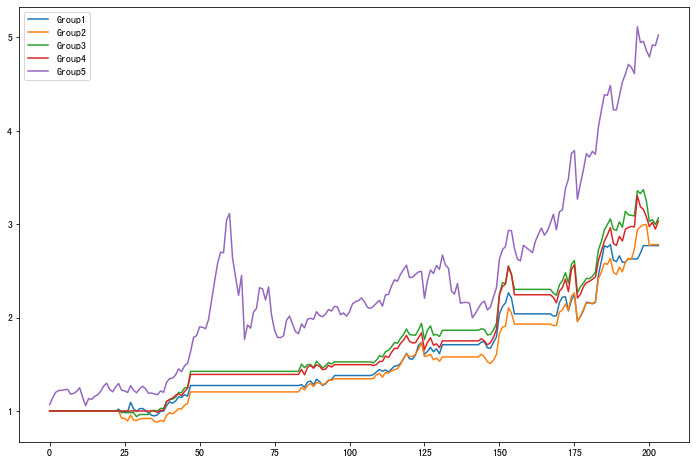

In [7]:
cnn_predict_S1.HierarchicalBacktest()

**Logistic Regression Hierarchical backtest**

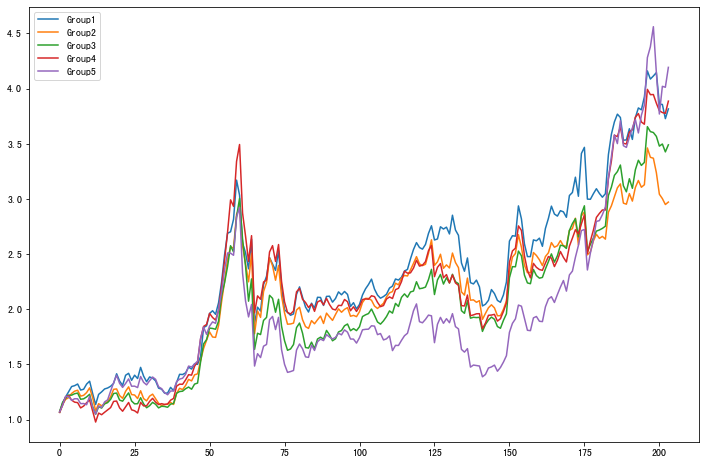

In [8]:
lr_predict_S1.HierarchicalBacktest()

**Random Forest Hierarchical backtest**

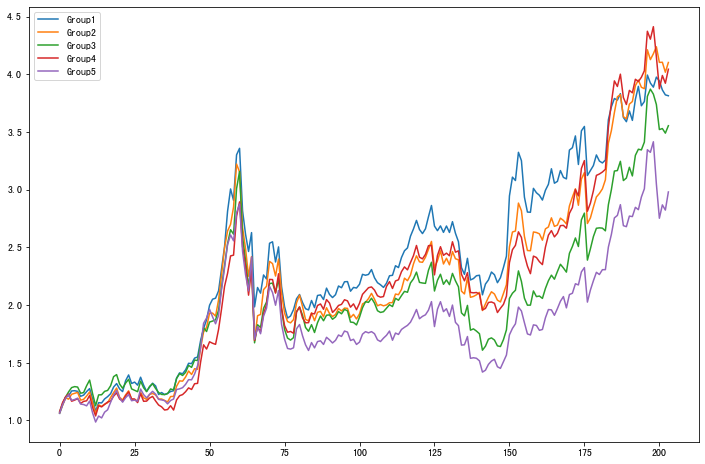

In [9]:
rf_predict_S1.HierarchicalBacktest()

## Net value backtest

In this part, we make backtest of each maching leaning method and draw the net value curve to compare it with IF300.

**CNN net value backtest**

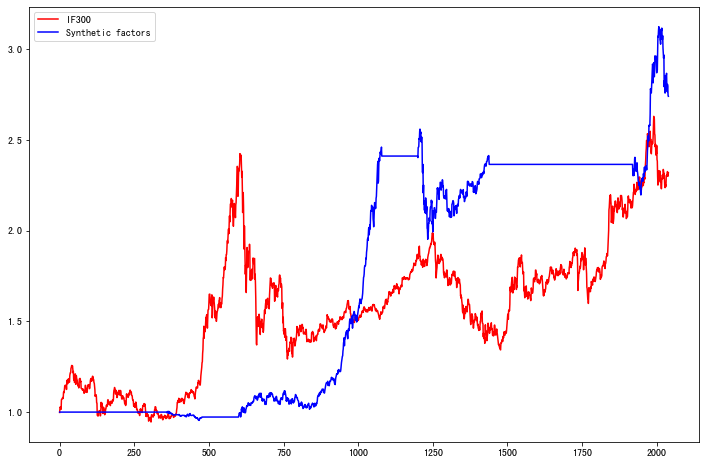

In [10]:
cnn_bt = bt.BackTest(position=pd.DataFrame((cnn_predict_w>0.5)+0), daily_return=pd.DataFrame(daily_return),window=10,
                          mv_weighted=True, ln_mv=pd.DataFrame(ln_mv))
cnn_result = cnn_bt.output_result()

**Logistic regression net value backtest**

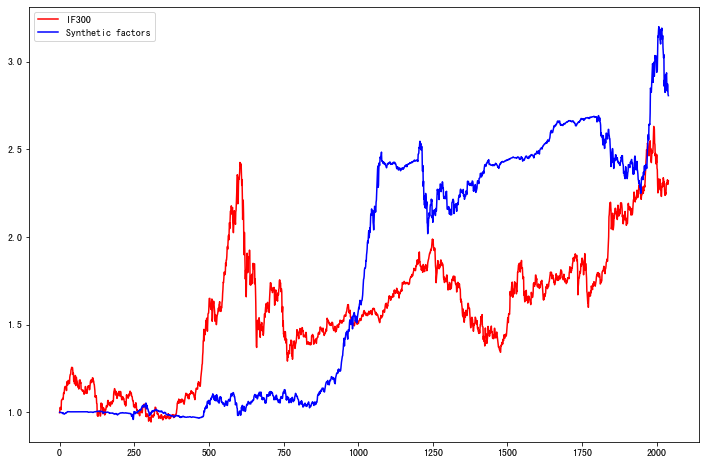

In [11]:
lr_bt = bt.BackTest(position=pd.DataFrame((lr_predict_w>0.5)+0), daily_return=pd.DataFrame(daily_return),window=10,
                          mv_weighted=True, ln_mv=pd.DataFrame(ln_mv))
lr_result = lr_bt.output_result()

**Random forest net value backtest**

Ramdom forset cannnot beat IF300.

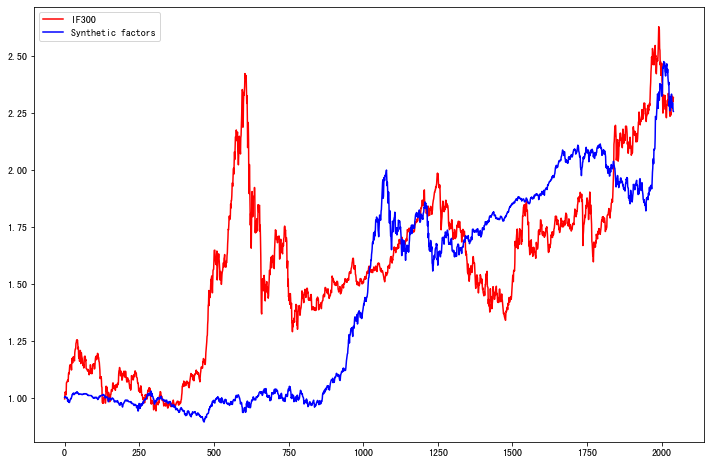

In [12]:
rf_bt = bt.BackTest(position=pd.DataFrame((rf_predict_w>0.5)+0), daily_return=pd.DataFrame(daily_return),window=10,
                          mv_weighted=True, ln_mv=pd.DataFrame(ln_mv))
rf_result = rf_bt.output_result()

In [14]:
net_value_analyze = pd.DataFrame(columns=['annualized rate of return ','annualized volatility','sharp ratio','maximum drawdown',],
                                 index=['CNN','Logistic regression','Random forest'])
net_value_analyze.loc['CNN',:] = ["%.2f%%" % (cnn_result['年化收益率']*100),
                                 "%.2f%%" % (cnn_result['年化波动率']*100),
                                 "%.2f" % (cnn_result['夏普比率']),
                                 "%.2f%%" % (cnn_result['最大回撤']*100)]
net_value_analyze.loc['Logistic regression',:] = ["%.2f%%" % (lr_result['年化收益率']*100),
                                 "%.2f%%" % (lr_result['年化波动率']*100),
                                 "%.2f" % (lr_result['夏普比率']),
                                 "%.2f%%" % (lr_result['最大回撤']*100)]
net_value_analyze.loc['Random forest',:] = ["%.2f%%" % (rf_result['年化收益率']*100),
                                                 "%.2f%%" % (rf_result['年化波动率']*100),
                                                 "%.2f" % (rf_result['夏普比率']),
                                                 "%.2f%%" % (rf_result['最大回撤']*100)]
net_value_analyze

annualized rate of return  annualized volatility  \
CNN                                     13.15%                12.46%   
Logistic regression                     13.48%                13.19%   
Random forest                           10.50%                12.48%   

                    sharp ratio maximum drawdown  
CNN                        1.06           12.28%  
Logistic regression        1.02           12.28%  
Random forest              0.84            8.83%